# Lab 6: Graphical Models

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD6"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L6_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from tqdm import tqdm
import networkx as nx
import scipy

In [2]:
from numpy.linalg import eigh, inv
class my_GLasso():
    
    def __init__(self, lambd=0.01, nu=0.01, max_iter = 60):
        '''
        Parameters:
        alpha : float
            Penalization parameter selected.
        mu: float>0

        Attributes:

    
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        precision_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.covariance_ = None
        self.precision_ = None
        self.graph = None
        self.lambd = lambd
        self.nu = nu
        self.max_iter = max_iter
        
    def fit(self, X):
        """ Fits the GraphicalLasso model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        # TODO
        
        n, p = X.shape
        S = np.cov(X.T)
        
        # 2. Initialize ADMM variables
        Lambda = np.identity(p)  # Primal variable (Precision)
        Y = np.zeros((p, p))     # Relaxed primal variable
        Z = np.zeros((p, p))     # Scaled dual variable
        
        threshold = self.lambd / self.nu
        def soft_threshold(Matrix,threshold = threshold):
            return np.sign(Matrix) * np.maximum(np.abs(Matrix) - threshold, 0)
            
        for _ in range(self.max_iter):
            #etape 1
            T = Y - Z -  S /self.nu
            eigvals, Q = eigh(T)
            
            # etape 2
            eigvals = 0.5 * (eigvals + np.sqrt(eigvals**2 + 4/self.nu))
            Lambda = Q @ np.diag(eigvals) @ Q.T
            Lambda =0.5* ( Lambda + Lambda.T)
            #etape 3
            Y = soft_threshold(Lambda + Z)
            np.fill_diagonal(Y, np.diag(Lambda + Z))

            #etape 4
            
            Z = Z + self.nu*(Lambda - Y)
        
        # Store final precision matrix
        self.precision_ = Y
        self.covariance_ = inv(self.precision_)
        self.graph = Y.copy()
        np.fill_diagonal(self.graph, 0)
        

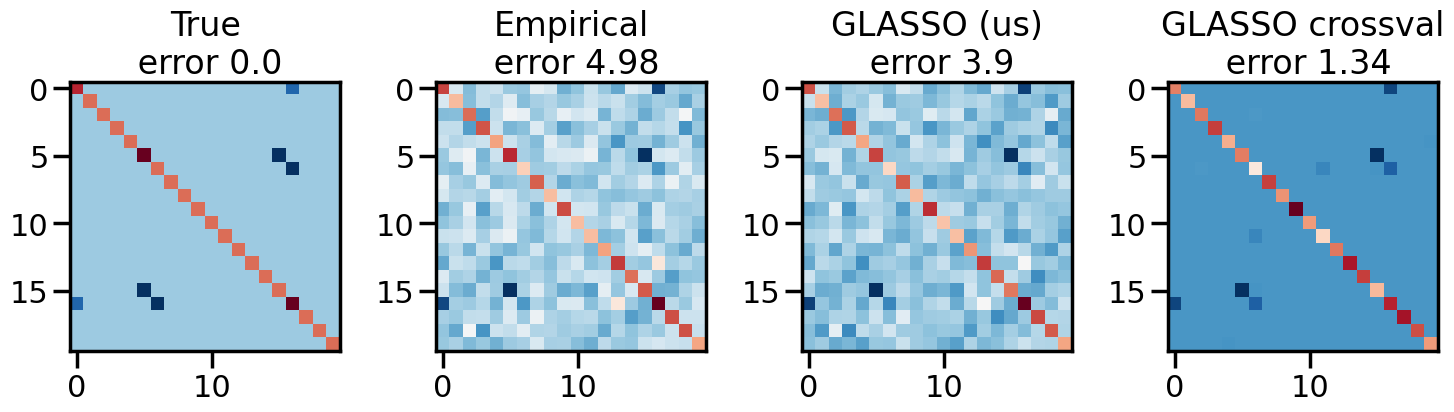

In [3]:
# TODO : Compare methods of estimating the covariance matrix in low-sample regime
n_samples = 60
n_features = 20

# Simulate data (multivariate gaussian)
from sklearn.datasets import make_sparse_spd_matrix
rng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98, smallest_coef=.4, largest_coef=.7, random_state=rng)
cov = np.linalg.inv(prec)
mean = np.zeros(n_features)
data = np.random.multivariate_normal(mean, cov, n_samples)
err = np.linalg.norm(prec - prec)

prec_empirical = np.linalg.inv(np.dot(data.T, data) / n_samples)
err_empirical = np.linalg.norm(prec - prec_empirical)

# Scikit-learn Graphical Lasso with cross validation 

from sklearn.covariance  import GraphicalLassoCV
GL_cv = GraphicalLassoCV()      
GL_cv.fit(data)
prec_glassocv = GL_cv.precision_
err_glassocv = np.linalg.norm(prec - prec_glassocv)

# Graphical Lasso estimation using our implementation
GL_mine = my_GLasso(lambd=0.01, nu=0.1, max_iter = int(1E4))
GL_mine.fit(data)
prec_glasso = GL_mine.precision_
err_glasso = np.linalg.norm(prec - prec_glasso)

# Visual comparison
titles = ["True", "Empirical", "GLASSO (us)", "GLASSO crossval"]
imgs = [prec, prec_empirical, prec_glasso, prec_glassocv]
errors = [err, err_empirical, err_glasso, err_glassocv]

ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
for idx, ax in enumerate(axes.flatten()):
    img = imgs[idx]
    error = np.around(errors[idx], decimals=2)
    title = titles[idx] + f'\n error {error}'
    ax.imshow(img, interpolation='nearest', cmap=plt.cm.RdBu_r)
    ax.set_title(title)
fig.tight_layout()

### Nodewise Regression

Fill in the following class that implements the nodewise regression algorithm to estimate a graphical model structure. You can use `LassoCV` for the regressions. Bonus (not graded): Implement your own cross-validation lasso.

In [4]:
from sklearn.linear_model import LassoCV
from tqdm import tqdm

class my_nodewise_regression():
    
    def __init__(self, rule='AND', eps=1e-6):
        '''
        Parameters:
        
        rule: {"OR", "AND"}
        
        Attributes:
        
        graph_structure_ : numpy.ndarray, shape (n_features, n_features)
            Estimated adjacancy matrix.        
        '''
        self.graph_structure_ = None
        self.rule = rule
        self.eps = eps
        
    def fit(self, X,max_iter=None):
        """ Fit the model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        #TODO
        
        S = np.zeros((X.shape[1],X.shape[1]), dtype=int)
        
        for j in tqdm(range(X.shape[1])):
            
            # regression lasso pour chaque element
            y_j = X[:, j]
            X_reg = np.delete(X, j, axis=1)
            lasso = LassoCV(cv=5,max_iter=max_iter)
            lasso.fit(X_reg, y_j)
            coefs_j = lasso.coef_
            coefs_j = np.insert(coefs_j, j, 0)
            S[j, :] = (np.abs(coefs_j) > self.eps).astype(int)
            
        # estimation de la structure de graph par "rule"
        
        if self.rule == 'AND':
            self.graph_structure_ = S * S.T
            
        elif self.rule == 'OR':
            self.graph_structure_ = ((S + S.T) > 0).astype(int)


In [5]:
np.random.seed(1)
n = 5000
p = 6
epsilon=1e-1
X = np.random.randn(n, p)
X.T[1] += X.T[0]
X.T[2] += X.T[1]
real_graph_structure = np.zeros((p, p))
real_graph_structure[0,1] = 1
real_graph_structure[1,0] = 1
real_graph_structure[1,2] = 1
real_graph_structure[2,1] = 1

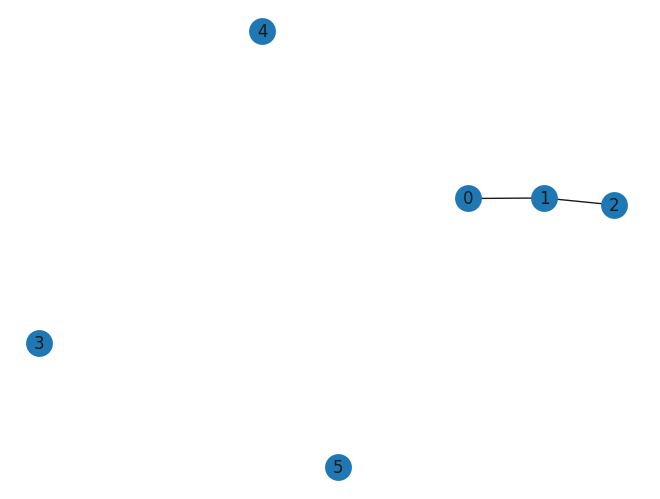

In [6]:
nx_real = nx.from_numpy_array(real_graph_structure.T)
nx.draw(nx_real, with_labels=True)

#On dessine la structure initiale

We notice that the initial graph is **poorly connected**, there are a lot of conditional independances between the components.

When we will reconstruct the graph with the predicted value of the precision matrix, **we expect higher values for the conditional correlation between nodes 0, 1 and 2**. 

However, based on what we saw before, we must expect a complete graph if we dont specify a minimum weight for the edges to be taken into account.

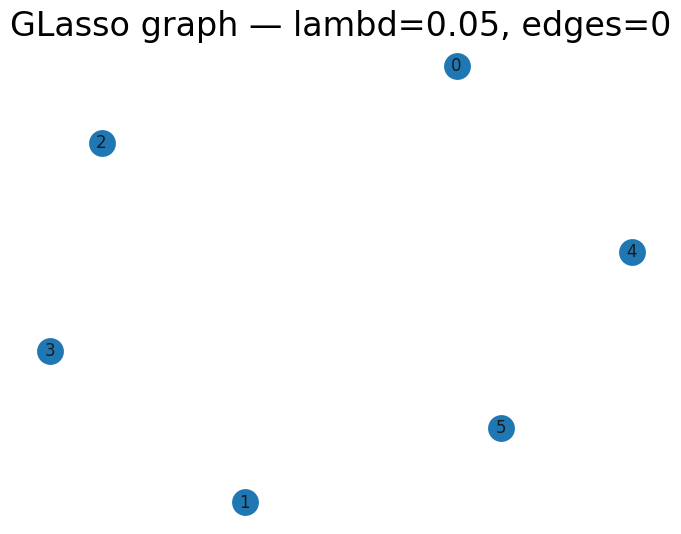

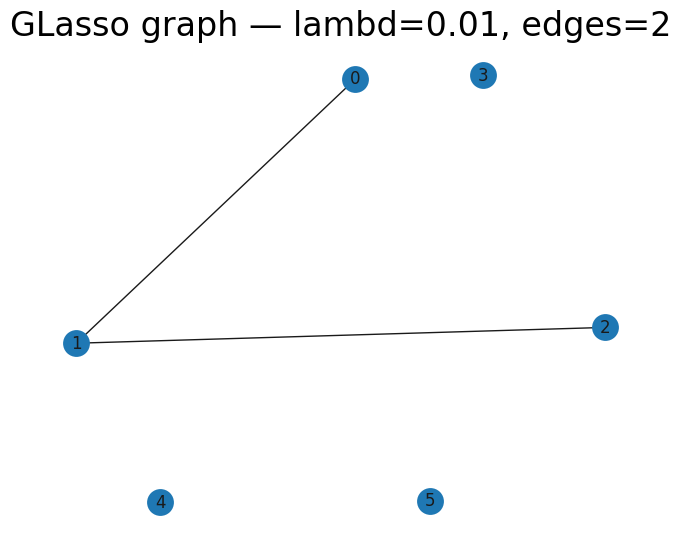

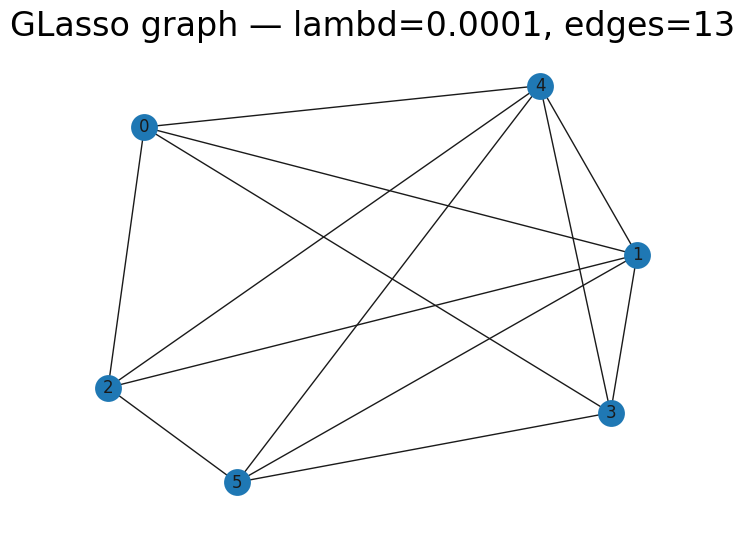

In [7]:
#TODO : plot the reconstructed graph with GLASSO using different thresholds. Comment the impact of the choice of the threshold

lambds = [0.05,0.01, 1E-4]
edge_counts = []

for lambd in lambds:
    GL = my_GLasso(lambd=lambd, max_iter=100)  
    GL.fit(X)
    
    G = nx.from_numpy_array(GL.graph)
    edge_counts.append(G.number_of_edges())
    
    plt.figure()
    nx.draw(G, with_labels=True)
    plt.title(f"GLasso graph — lambd={lambd}, edges={G.number_of_edges()}")
    plt.show()


### **comment:** We've observed that decreasing 'lambd' results in a denser, more permissive graph. This is a direct mechanical consequence of the soft-thresholding step, which uses 'lambda / nu' as its threshold. A larger 'lambda' makes this threshold lower, thus being more permissive and zeroing out fewer small correlations.

100%|██████████| 6/6 [00:00<00:00, 21.43it/s]


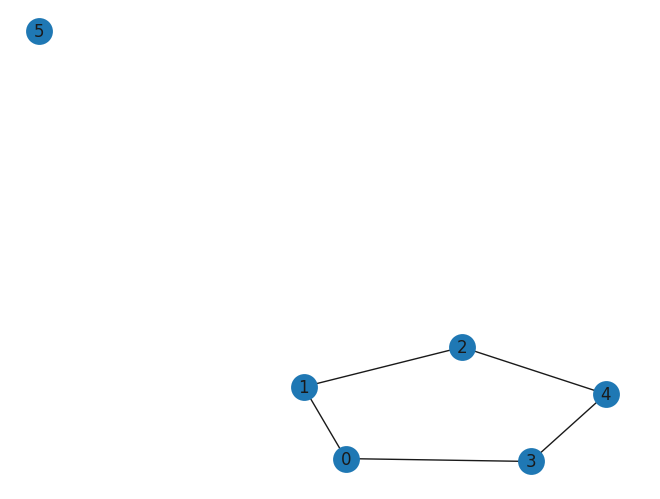

In [8]:
#TODO : plot the reconstructed graph with nodewise regression using the rule OR
nodewise = my_nodewise_regression(rule="OR")
nodewise.fit(X,max_iter=int(1E2))
nx_ndws_OR = nx.from_numpy_array(nodewise.graph_structure_.T)
nx.draw(nx_ndws_OR, with_labels=True)


100%|██████████| 6/6 [00:00<00:00, 19.75it/s]


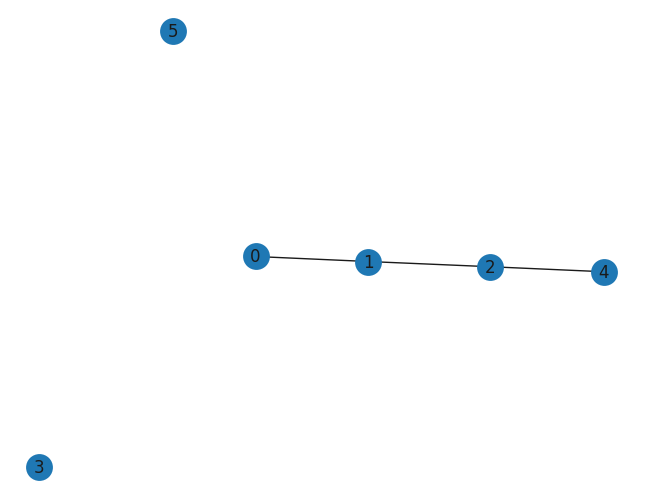

In [9]:
#TODO : plot the reconstructed graph with nodewise regression using the rule OR
nodewise = my_nodewise_regression(rule="AND")
nodewise.fit(X,max_iter=int(1E2))
nx_ndws_OR = nx.from_numpy_array(nodewise.graph_structure_.T)
nx.draw(nx_ndws_OR, with_labels=True)

## Simulations

Compare the two graph estimators for each of the following models with $p = 300$ and $n = 40, 80, 320$:

- An AR(1)-Block model. In this model the *covariance* matrix is block-diagonal with equalsized AR(1)-blocks of the form $(\Sigma_{Block})_{i, j} = 0.9^{|i−j|}$, take $30 \times 30$ blocks.
- The exponential decay model considered in Fan et al. [2009]. In this model we consider a case where no element of the concentration matrix is exactly zero. The elements of $\Theta$ are given by $\Theta_{ij} = \exp{(−2|i − j|)}$ equals essentially zero when the difference |i − j| is large.

For GLasso estimation, use cross-validation k-fold with loglikelihood loss to select the $\lambda$ penalization parameter. Evaluate your estimation using the Froebenius matrix norm. 

For Node-regression estimation, compare your edge-estimation with the binary (thresholded) covariance matrix. Evaluate your estimation using accuracy and the F1 score. 

In [10]:
# DATA generation:
from scipy.linalg import toeplitz, block_diag
def ar1_block_cov(p=300, block_size=30, rho=0.9):
    """Return block diagonal covariance matrix of p dimensions."""
    assert p % block_size == 0
    B = toeplitz(rho ** np.arange(block_size))
    blocks = [B for _ in range(p // block_size)]
    return block_diag(*blocks)
    
def exp_decay_cov(p=300, alpha=2):
    return np.exp(-alpha * np.abs(np.arange(p)[:, None] - np.arange(p)[None, :]))

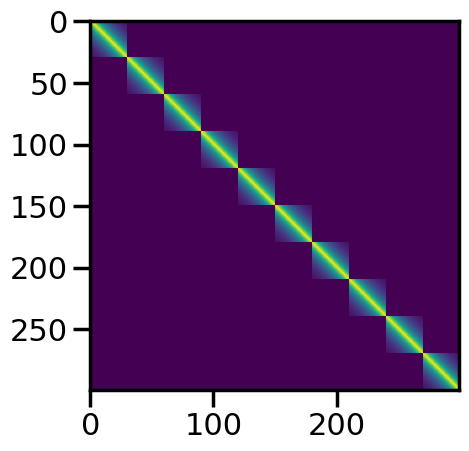

In [11]:
plt.imshow(ar1_block_cov())

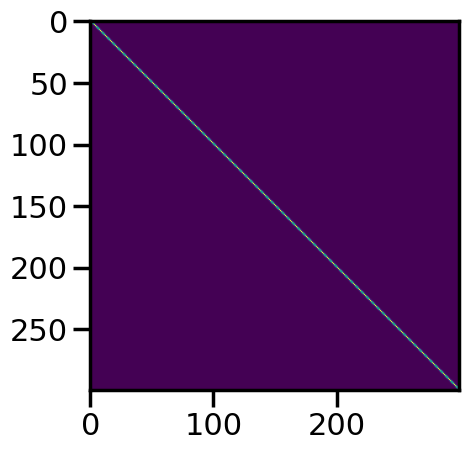

In [12]:
plt.imshow(exp_decay_cov(alpha=2))

In [13]:
# data sampling
def sample_data(Sigma, n=320):
    p = Sigma.shape[0]
    return np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)
Sigma1= ar1_block_cov()
Sigma2= exp_decay_cov(p=300, alpha=2)
sampled_data= {}
for num_samples in {40,80,320}:
    sampled_data[f"AR1_{num_samples}"] = sample_data(Sigma1, n=num_samples)
for num_samples in {40,80,320}:
    sampled_data[f"expo_decay{num_samples}"] = sample_data(Sigma2, n=num_samples)

In [14]:
# Kfolds selection
from sklearn.covariance import GraphicalLassoCV
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")

glasso_cv_results = {}  # to store best lambda and precision matrices

for name, X in sampled_data.items():
    print(f"\n=== GLassoCV on {name} ===")
    
    # Graphical Lasso with k-fold CV (log-likelihood loss)
    gl_cv = GraphicalLassoCV(cv=5)   # you can change 5 → k you want
    gl_cv.fit(X)
    
    best_lambda = gl_cv.alpha_       # this is the λ selected by CV
    Theta_hat = gl_cv.precision_     # estimated precision matrix
    
    glasso_cv_results[name] = {
        "lambda": best_lambda,
        "precision": Theta_hat,
        "model": gl_cv,
    }
    
    print(f"Best lambda (alpha) for {name}: {best_lambda:.4f}")



=== GLassoCV on AR1_40 ===
Best lambda (alpha) for AR1_40: 0.3321

=== GLassoCV on AR1_80 ===
Best lambda (alpha) for AR1_80: 0.2985

=== GLassoCV on AR1_320 ===
Best lambda (alpha) for AR1_320: 0.2508

=== GLassoCV on expo_decay40 ===
Best lambda (alpha) for expo_decay40: 0.5754

=== GLassoCV on expo_decay80 ===
Best lambda (alpha) for expo_decay80: 0.3640

=== GLassoCV on expo_decay320 ===
Best lambda (alpha) for expo_decay320: 0.1510


AR1_40:error frobenius 212.4190


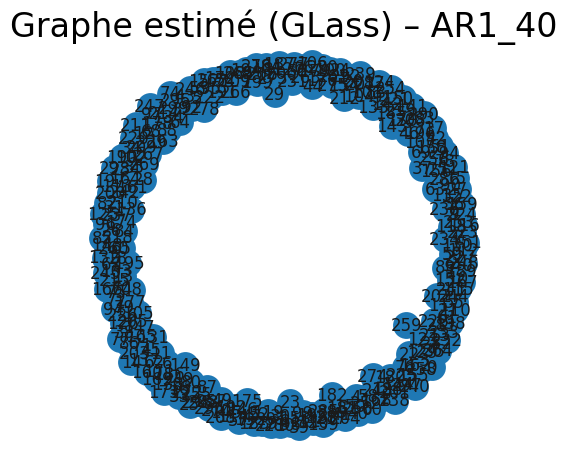

AR1_80:error frobenius 129.2679


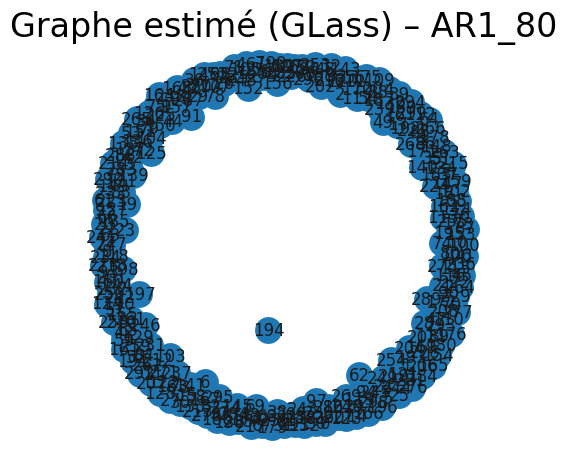

AR1_320:error frobenius 117.9789


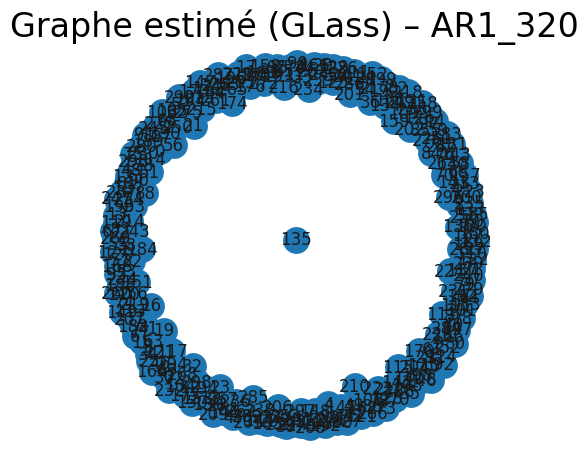

expo_decay40:error frobenius 318.5916


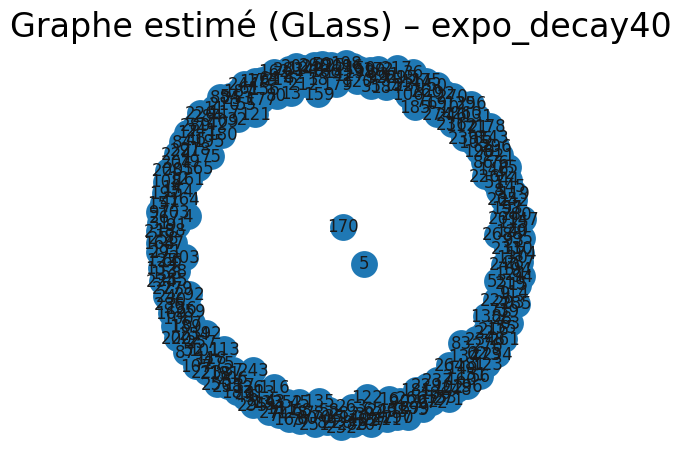

expo_decay80:error frobenius 182.6693


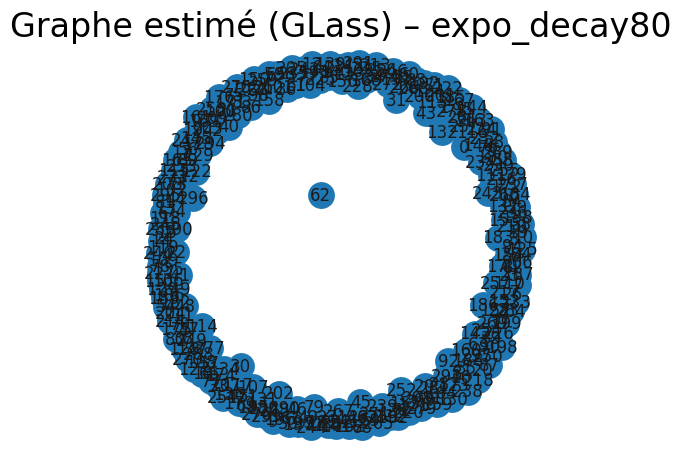

expo_decay320:error frobenius 33.6340


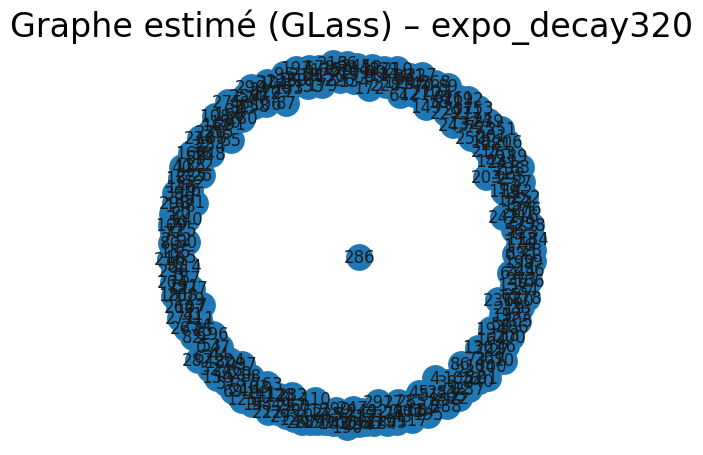

In [15]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


Theta1 = np.linalg.inv(Sigma1)  # AR(1)-block model
Theta2 = np.linalg.inv(Sigma2)  # exponential decay model

frob_errors = {}  # store Frobenius errors per dataset

for name, X in sampled_data.items():  

    GL = my_GLasso(lambd=0.1, max_iter=60) 
    GL.fit(X)
    Theta_hat = GL.precision_

    if name.startswith("AR1_"):
        Theta_true = Theta1
    elif name.startswith("expo_decay"):
        Theta_true = Theta2
    
    # Frobenius norm 
    err_frob = np.linalg.norm(Theta_true - Theta_hat, ord="fro")
    frob_errors[name] = err_frob
    print(f"{name}:error frobenius {err_frob:.4f}")
    
    # --- 4. Graph construction for plotting ---
    # build adjacency from precision (non-zero entries)
    A_hat = (np.abs(Theta_hat) > 1e-6).astype(int)
    np.fill_diagonal(A_hat, 0)

    G = nx.from_numpy_array(A_hat)  # (was nodewise.graph_structure_ before)

    plt.figure(figsize=(4, 4))
    nx.draw(G, with_labels=True)
    plt.title(f"Graphe estimé (GLass) – {name}")
    plt.tight_layout()
    plt.show()


In [16]:
from sklearn.metrics import accuracy_score, f1_score
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

tau = 0.05  # threshold for the true covariance, you can tune this

nodewise_scores_OR = {}

for name, X in sampled_data.items():
    
    # Nodewise regression estimator
    nodewise = my_nodewise_regression(rule="OR")
    nodewise.fit(X, max_iter=100)
    A_node = nodewise.graph_structure_.astype(int)
    np.fill_diagonal(A_node, 0)
    
    # Choose the TRUE covariance matrix according to the model
    if name.startswith("AR1_"):
        Sigma_true = Sigma1
    else:
        Sigma_true = Sigma2

    
    # Binary (thresholded) TRUE covariance matrix
    A_cov = (np.abs(Sigma_true) > tau).astype(int)
    np.fill_diagonal(A_cov, 0)
    
    # Compare edges on upper-triangular part
    iu, ju = np.triu_indices_from(A_cov, k=1)
    y_true = A_cov[iu, ju]
    y_pred = A_node[iu, ju]
    
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    nodewise_scores_OR[name] = {"accuracy": acc, "f1": f1}
    print(f"{name} – accuracy = {acc:.3f}, F1 = {f1:.3f}")


100%|██████████| 300/300 [00:32<00:00,  9.31it/s]


AR1_40 – accuracy = 0.870, F1 = 0.207


100%|██████████| 300/300 [00:50<00:00,  5.98it/s]


AR1_80 – accuracy = 0.881, F1 = 0.200


100%|██████████| 300/300 [02:32<00:00,  1.97it/s]


AR1_320 – accuracy = 0.890, F1 = 0.203


100%|██████████| 300/300 [00:29<00:00, 10.17it/s]


expo_decay40 – accuracy = 0.957, F1 = 0.022


100%|██████████| 300/300 [00:47<00:00,  6.27it/s]


expo_decay80 – accuracy = 0.961, F1 = 0.041


100%|██████████| 300/300 [06:18<00:00,  1.26s/it]

expo_decay320 – accuracy = 0.964, F1 = 0.158


In [17]:
from sklearn.metrics import accuracy_score, f1_score
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

tau = 0.05  # threshold for the true covariance, you can tune this

nodewise_scores_AND = {}

for name, X in sampled_data.items():
    
    # Nodewise regression estimator
    nodewise = my_nodewise_regression(rule="AND")
    nodewise.fit(X, max_iter=100)
    A_node = nodewise.graph_structure_.astype(int)
    np.fill_diagonal(A_node, 0)
    
    # Choose the TRUE covariance matrix according to the model
    if name.startswith("AR1_"):
        Sigma_true = Sigma1
    else:
        Sigma_true = Sigma2

    
    # Binary (thresholded) TRUE covariance matrix
    A_cov = (np.abs(Sigma_true) > tau).astype(int)
    np.fill_diagonal(A_cov, 0)
    
    # Compare edges on upper-triangular part
    iu, ju = np.triu_indices_from(A_cov, k=1)
    y_true = A_cov[iu, ju]
    y_pred = A_node[iu, ju]
    
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    nodewise_scores_AND[name] = {"accuracy": acc, "f1": f1}
    print(f"{name} – accuracy = {acc:.3f}, F1 = {f1:.3f}")


100%|██████████| 300/300 [00:32<00:00,  9.21it/s]


AR1_40 – accuracy = 0.910, F1 = 0.155


100%|██████████| 300/300 [00:50<00:00,  5.98it/s]


AR1_80 – accuracy = 0.910, F1 = 0.159


100%|██████████| 300/300 [02:27<00:00,  2.03it/s]


AR1_320 – accuracy = 0.911, F1 = 0.159


100%|██████████| 300/300 [00:29<00:00, 10.19it/s]


expo_decay40 – accuracy = 0.990, F1 = 0.025


100%|██████████| 300/300 [00:47<00:00,  6.29it/s]


expo_decay80 – accuracy = 0.988, F1 = 0.048


100%|██████████| 300/300 [06:11<00:00,  1.24s/it]

expo_decay320 – accuracy = 0.989, F1 = 0.253
